In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Sensitivity Analysis: Solar Radiation

## Table of Contents
1. [Workflow](#workflow)
    1. [Calculating Solar Radiation](#calculating-solar-radiation)
    2. [Fitting the Sine Curve](#fitting-the-sine-curve)
    3. [Justification for using yearly average temperature](#justification-for-using-yearly-average-temperature)
    4. [Noise](#Noise)
    5. [Comparison with empirical data](#comparison-with-empirical-data)
2. [Sensitivity Analysis](#sensitivity-analysis)
    1. [Latitude and day of the year](#latitude-and-day-of-the-year)
    2. [Temperature](#temperature)
    3. [Optional Parameters](#optional-parameters)

The solar radiation calculations are mainly based on [Allen et al. 1998](https://agris.fao.org/search/en/providers/122621/records/647231eb53aa8c896301eadc) and are strongly inspired by [PyETo](https://github.com/woodcrafty/PyETo). However, the goal was to implement the module without the need for external and discontinued libraries which is why the calculations are implemented from scratch.  

## Workflow

The module is designed to calculate the solar radiation from latitude, day of the year, and minimum and maximum temperature. Calculated solar radiation is then used to fit a sine curve that can be used to sufficiently estimate solar radiation for any given day without the need for extensive calculations at every time step.  

### Calculating Solar Radiation

Solar radiation calculations need latitude, day of year and minimum and maximum temperature as input parameter. The following equations and assumptions are based on Allen et al. 1998:  

In [2]:
def calculateSolarRadiation(doy,lat,tmin,tmax):
    # albedo
    a = 0.23 # albedo value is assumed to be constant, representing a fitting value green vegetation (0.20-0.25).
    # solar declination
    d = 0.409*np.sin((2*np.pi/365)*doy-1.39)
    # sunset hour angle 
    w_s_temp = -np.tan(lat)*np.tan(d) 
    w_s = np.arccos(min(max(w_s_temp, -1), 1)) # if >= 1, 24hrs of daylight, if <= -1, 24hrs of darkness
    # inverse relative distance Earth-Sun based on doy
    ird = 1 + (0.033*np.cos((2*np.pi/365)*doy))
    # extraterrestrial radiation
    R_a_temp1 = ((24*60)/np.pi)
    R_a_temp2 = w_s * np.sin(lat) * np.sin(d)
    R_a_temp3 = np.cos(lat) * np.cos(d) * np.sin(w_s)
    R_a = R_a_temp1 * 0.0820 * ird * (R_a_temp2 + R_a_temp3)
    # incoming solar radiation 
    # assuming distance to coastline <= 20km, to avoid needing additional radiation data
    # this is a simplification, that applies to mangrove-saltmarsh ecotones.
    R_s = (0.7*R_a)-4 
    # net shortwave radiation
    R_ns = (1-a)*R_s
    # actual vapor pressure
    e_a = 0.611 * np.exp((17.27 * tmin) / (tmin + 237.3)) 
    # clear sky radiation
    # Altitude is assumend to be 0 which is a fitting estimate for mangrove-saltmarsh ecotones.
    altitude = 0
    R_so = (0.00002 * altitude + 0.75)*R_a
    # net longwave radiation
    R_nl = 0.000000004903*(((tmax)**4+(tmin)**4)/2)*(0.34-(0.14*np.sqrt(e_a)))*(1.35*(R_s/R_so)-0.35)
    # daily net radiation
    R_n = R_ns - R_nl
    return R_n

In [3]:
# input:
doy = 15 # day of year
lat = 0.65 # latitude in radians
tmin = 23.1 # minimum temperature in deg C
tmax = 29.9 # maximum temperature in deg C

calculateSolarRadiation(doy,lat,tmin,tmax)

5.924590934600382

### Fitting the sine curve

The sine curve is fitted to the prior calculated solar radiation based on temperature values and latitude. The curve parameters can then be used to estimate solar radiation for any given day of the year.  

In [4]:
# calculating monthly solar radiation
# input: lat (radians), monthly tmin and tmax (deg C) 
tmin = [23.1,23.2,23.6,24.6,25.2,24.9,24.7,24.7,25.1,24.8,24.4,23.7]
tmax = [29.9,29.8,30.2,30.6,31,30.9,30.8,31.2,31.5,31.3,30.9,30.3]
lat = 0.65
doy15 = [15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]

solar_radiation_data = []
for doy, tmin, tmax in zip(doy15, tmin, tmax):
    results = calculateSolarRadiation(doy,lat,tmin,tmax)
    # save dailyNetRad to list
    solar_radiation_data.append(results)

In [5]:
# defining the basic sine wave function
def sine_function(t, amplitude, frequency, phase_shift, vertical_shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + phase_shift) + vertical_shift

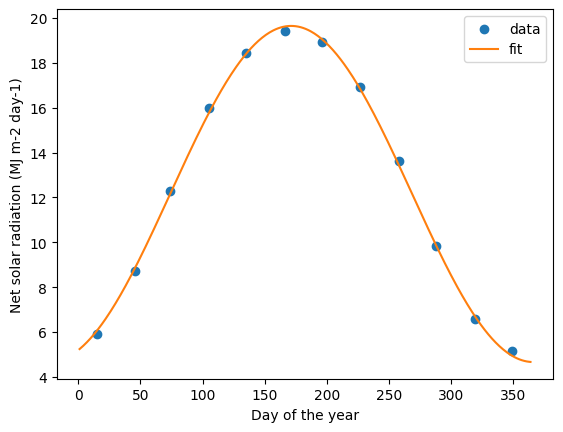

In [6]:
# fit the curve to the solar radiation data and extract the curve parameters
popt, pcov = curve_fit(sine_function, doy15, solar_radiation_data)

# extrapolate radiation over a year
doy365 = np.arange(1, 365, 1)
solar_radiation_fit = sine_function(doy365, *popt)

# plot the solar radiation data and the fitted curve
plt.scatter(doy15, solar_radiation_data, color="tab:blue", label='data')
plt.plot(doy365, solar_radiation_fit, color="tab:orange", label='fit')
plt.xlabel('Day of the year')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.legend()

### Justification for using yearly average temperature

Testing showed, that the difference between using monthly average temperature values or yearly average temperature values is negligible for fitting the sine curve. We decided to use yearly average temperature values to reduce the number of input parameters without losing accuracy.  

**Example:** The following code fits the sine curve using yearly average temperature values and compares to the curve that was fitted using monthly average temperature values.   

In [7]:
# repeat calculations using yearly mean temperatures
tmin_year = np.mean(tmin)
tmax_year = np.mean(tmax)
solar_radiation_yearly = []
for doy in doy15: 
    results = calculateSolarRadiation(doy,lat,tmin,tmax)
    # save dailyNetRad to list
    solar_radiation_yearly.append(results)

# fit the curve to the solar radiation data and extract the curve parameters
popt_yearly, pcov_yearly = curve_fit(sine_function, doy15, solar_radiation_yearly)

# extrapolate radiation over a year
solar_radiation_yearlyfit = sine_function(doy365, *popt_yearly)

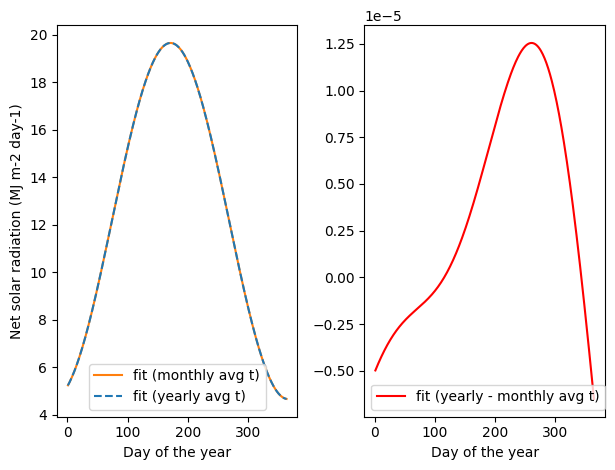

In [8]:
# comparing monthly and yearly solar radiation
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(doy365, solar_radiation_fit, color="tab:orange", label='fit (monthly avg t)')
ax1.plot(doy365, solar_radiation_yearlyfit, linestyle="--", color="tab:blue", label='fit (yearly avg t)')
ax1.set_ylabel('Net solar radiation (MJ m-2 day-1)')
ax1.set_xlabel('Day of the year')
ax1.legend()
solar_radiation_difference = solar_radiation_yearlyfit - solar_radiation_fit
ax2.plot(doy365, solar_radiation_difference, color="red", label=("fit (yearly - monthly avg t)"))
ax2.set_xlabel('Day of the year')
ax2.legend()
plt.tight_layout()

While accuracy of temperature data does impact the solar radiation calculations, the difference between using monthly and yearly average temperature values is around $10^{-5}$ MJ m-2 day-1 and therefore negligible for our use case.  
A quick t-test shows that the difference between both calculations is not significant:  

In [9]:
from scipy.stats import ttest_ind
calculated_data = ttest_ind(solar_radiation_yearly, solar_radiation_data)
alpha = 0.05
if calculated_data[1] < alpha:
    print("Differences between calculated solar radiation data are statistically significant, p = " + str(calculated_data[1]))
else:
    print("Differences between calculated solar radiation data are not statistically significant, p = " + str(calculated_data[1]))

Differences between calculated solar radiation data are not statistically significant, p = 0.9999986708528346


In [10]:
fitted_data = ttest_ind(solar_radiation_yearlyfit, solar_radiation_fit)
if fitted_data[1] < alpha:
    print("Differences between fitted solar radiation data are statistically significant, p = " + str(fitted_data[1]))
else:
    print("Differences between fitted solar radiation data are not statistically significant, p = " + str(fitted_data[1]))

Differences between fitted solar radiation data are not statistically significant, p = 0.9999922821014777


### Noise

Since we are assuming clear sky radiation, noise is assumed to only reduce solar radiation. Since evidence for natural fluctuations in radiation is scarce, noise is assumend to be normally distributed with a mean of half the standard deviation of the solar radiation to be comparable to empiric data ([Barr et al. 2014](https://doi.org/10.1002/2013JD021083)).  
Barr et al. 2014 further suggests that the moving average of solar radiation between may and november is roughly constant. This is implemented in the default noise calculations and equates to a normal distribution with a mean of four times the standard deviation.

### Comparison with empirical data
Barr et al. 2014 conducted an extensive study on seasonal evapotranspiration patterns in mangrove forests and included net solar radiation as an environmental variable in their measurements. The data was collected in a subtropical mangrove forest in the Everglades National Park, Florida. We will use our script to estimate solar radiation for the same location and compare it to the empirical data. The Everglades National Park is located at 0.4416° N latitude. Because of the direct proximity to the Florida Bay our assumption of altitude at sea level is sufficient. . Air temperature is reported by Barr et al. 2014. Maximum temperature is rougly 31 °C and minimum temperature is rougly 13 °C.  

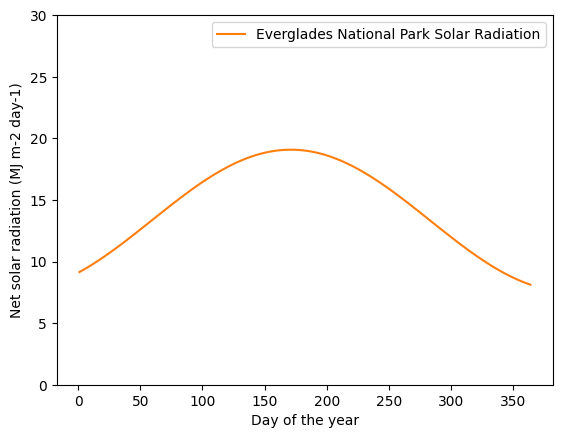

In [11]:
# input
tmin = 31
tmax = 13
lat = 0.4416

# calculating monthly solar radiation
netrad_barr = []
doy15 = [15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
for doy in doy15:
    results = calculateSolarRadiation(doy,lat,tmin,tmax)
    netrad_barr.append(results)

# fitting
popt, pcov = curve_fit(sine_function, doy15, netrad_barr)
doy365 = np.arange(1, 365, 1)
netrad_barr_fit = sine_function(doy365, *popt)

# plot the solar radiation data and the fitted curve
plt.plot(doy365, netrad_barr_fit, color="tab:orange", label='Everglades National Park Solar Radiation')
plt.xlabel('Day of the year')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.ylim(0, 30)
plt.legend()

When comparing the fitted solar radiation to Figure 1(e) from Barr et al. 2014, we can see that the curve fits the data well. 

## Sensitivity Analysis
### Latitude and day of the year
Using latitude and day of the year (doy) as bifurcation parameter to assess their influence on net solar radiation.  
Allen et al. 1998 additionally suggests limited validity of solar radiation calculations for latitude above 55 degrees (0.9599 rad) North and South.  

In [12]:
# 2d heatmap for latitude and doy
lat_range = np.linspace(-0.9599, 0.9599, 365)
doy_range = np.arange(1, 366, 1)

twod_results = np.zeros((len(lat_range), len(doy_range)))

i = 0
j = 0
for lat in lat_range: 
    j = 0
    for doy in doy_range:
        twod_results[i,j] = calculateSolarRadiation(doy,lat,tmin,tmax)
        j += 1
    i += 1

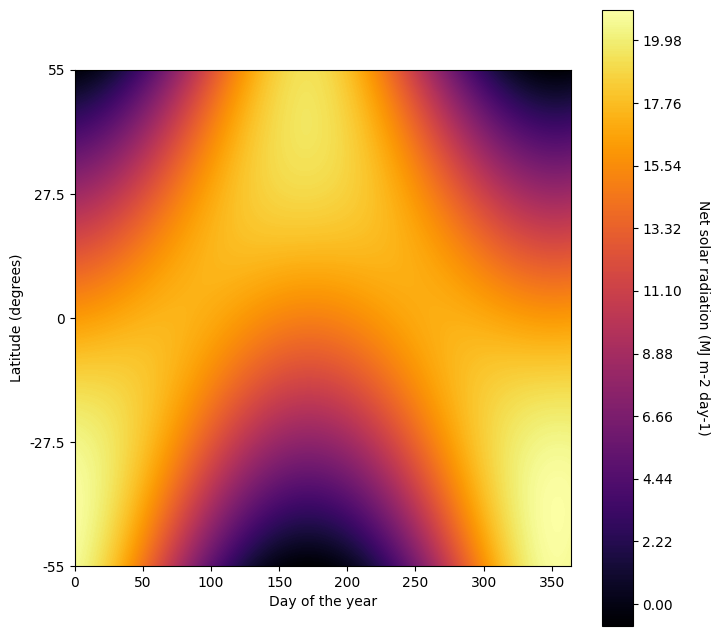

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
im = plt.contourf(twod_results, cmap='inferno', levels=365)
cbar = fig.colorbar(im)
cbar.set_label('Net solar radiation (MJ m-2 day-1)', rotation=270, labelpad=20)
ax.set_yticks(np.linspace(0, 364, 5))
ax.set_yticklabels(['-55', '-27.5', '0', '27.5', '55'])
plt.xlabel('Day of the year')
plt.ylabel('Latitude (degrees)')
plt.axis('square')
plt.show()

Day of the year and latitude are vital parameters for solar radiation calculations. Depending on the location and time of the year, the yearly trend of solar radiation varies significantly.  

### Temperature
Temperature as bifurcation parameter to assess its influence on net solar radiation.  

Variance_tmin: 1.8527279896743206e-09
Variance_tmax: 7.857107715103943e-09


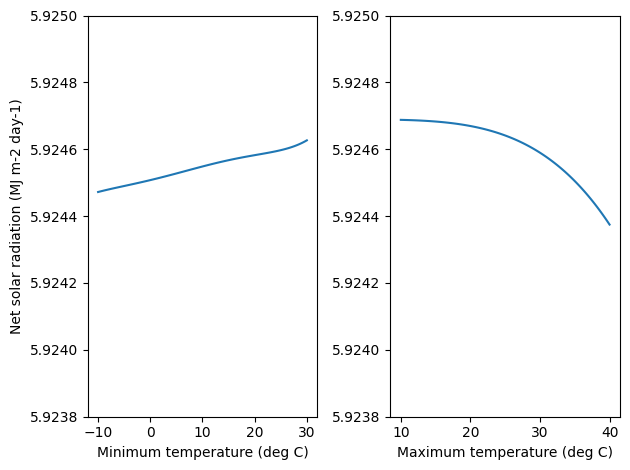

In [19]:
# tmin as bifurcation parameter
tmin_range = np.linspace(-10, 30, 100)
lat = 0.65
doy = 15 
tmax = 29.9

tmin_results = []
for tmin in tmin_range:
    tmin_results.append(calculateSolarRadiation(doy,lat,tmin,tmax))

# tmax as bifurcation parameter
tmax_range = np.linspace(10, 40, 100)
lat = 0.65
tmin = 23.1

tmax_results = []
for tmax in tmax_range:
    tmax_results.append(calculateSolarRadiation(doy,lat,tmin,tmax))

print("Variance_tmin: " + str(np.var(tmin_results)))
print("Variance_tmax: " + str(np.var(tmax_results)))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(tmin_range, tmin_results)
ax1.set_xlabel('Minimum temperature (deg C)')
ax1.set_ylabel('Net solar radiation (MJ m-2 day-1)')
ax1.set_ylim(5.9238, 5.925)

ax2.plot(tmax_range, tmax_results)
ax2.set_xlabel('Maximum temperature (deg C)')
ax2.set_ylim(5.9238, 5.925)
plt.tight_layout()
plt.show()

The differences in solar radiation are minimal to the point where  difference of 30 °C results in a difference of less than 0.001 MJ m-2 day-1. When net solar radiation values of as high as 20 MJ m-2 day-1, this difference is almost negligible (See [Justification for using yearly average temperature](#Justification-for-using-yearly-average-temperature)).

### Optional Parameters
In the following, the function for the solar radiation calculations is slightly varied to allow for additional analysis of albedo and altitude as optional input parameters.

In [15]:
def calculateSolarRadiationOptional(doy,lat,tmin,tmax, altitude, albedo):
    # albedo
    a = albedo # albedo value is assumed to be constant, representing a fitting value green vegetation (0.20-0.25).
    # solar declination
    d = 0.409*np.sin((2*np.pi/365)*doy-1.39)
    # sunset hour angle 
    w_s_temp = -np.tan(lat)*np.tan(d) 
    w_s = np.arccos(min(max(w_s_temp, -1), 1)) # if >= 1, 24hrs of daylight, if <= -1, 24hrs of darkness
    # inverse relative distance Earth-Sun based on doy
    ird = 1 + (0.033*np.cos((2*np.pi/365)*doy))
    # extraterrestrial radiation
    R_a_temp1 = ((24*60)/np.pi)
    R_a_temp2 = w_s * np.sin(lat) * np.sin(d)
    R_a_temp3 = np.cos(lat) * np.cos(d) * np.sin(w_s)
    R_a = R_a_temp1 * 0.0820 * ird * (R_a_temp2 + R_a_temp3)
    # incoming solar radiation 
    # assuming distance to coastline <= 20km, to avoid needing additional radiation data
    # this is a simplification, that applies to mangrove-saltmarsh ecotones.
    R_s = (0.7*R_a)-4 
    # net shortwave radiation
    R_ns = (1-a)*R_s
    # actual vapor pressure
    e_a = 0.611 * np.exp((17.27 * tmin) / (tmin + 237.3)) 
    # clear sky radiation
    # Altitude is assumend to be 0 which is a fitting estimate for mangrove-saltmarsh ecotones.
    Altitude = altitude
    R_so = (0.00002 * Altitude + 0.75)*R_a
    # net longwave radiation
    R_nl = 0.000000004903*(((tmax)**4+(tmin)**4)/2)*(0.34-(0.14*np.sqrt(e_a)))*(1.35*(R_s/R_so)-0.35)
    # daily net radiation
    R_n = R_ns - R_nl
    return R_n

In [16]:
# input:
doy = 15 # day of year
lat = 0.65 # latitude in radians
tmin = 23.1 # minimum temperature in deg C
tmax = 29.9 # maximum temperature in deg C
altitude = 0 # altitude
albedo = 0.23 # albedo

calculateSolarRadiationOptional(doy,lat,tmin,tmax, altitude, albedo)

5.924590934600382

Max net solar radiation at altitude = 100 m: 5.924591547425201
Min net solar radiation at altitude = 0 m: 5.924590934600382
Range net solar radiation: 6.128248184467111e-07


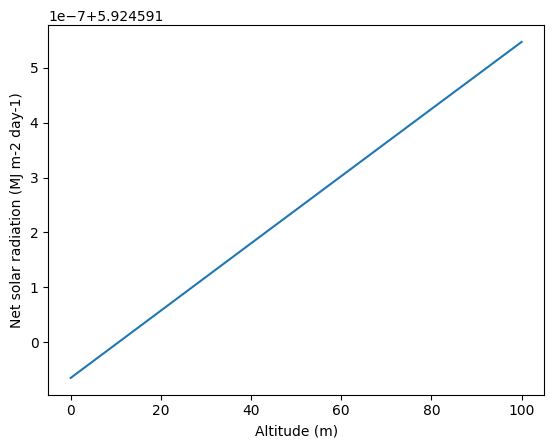

In [17]:
# latitude as bifurcation parameter
altitude_range = np.linspace(0, 100, 500)

altitude_results = np.zeros(len(altitude_range))

i = 0
for altitude in altitude_range: 
    altitude_results[i] = calculateSolarRadiationOptional(doy, lat, tmin, tmax, altitude, albedo)
    i += 1

print("Max net solar radiation at altitude = 100 m: " + str(np.max(altitude_results)))
print("Min net solar radiation at altitude = 0 m: " + str(np.min(altitude_results)))
print("Range net solar radiation: " + str(np.max(altitude_results) - np.min(altitude_results)))
plt.plot(altitude_range, altitude_results)
plt.xlabel('Altitude (m)')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.show()

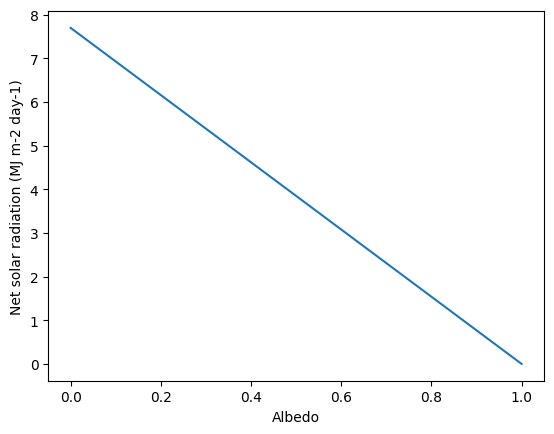

In [18]:
# latitude as bifurcation parameter
albedo_range = np.linspace(0, 1, 500)

albedo_results = np.zeros(len(albedo_range))

i = 0
for albedo in albedo_range: 
    albedo_results[i] = calculateSolarRadiationOptional(doy,lat,tmin,tmax, altitude, albedo)
    i += 1

plt.plot(albedo_range, albedo_results)
plt.xlabel('Albedo')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.show()

* Influence of altitude on solar radiation is minimal which underlines the assumption of the default sea level altitude at 0 m. 
* Albedo has a strong negative impact on solar radiation. The higher the albedo, the less solar radiation is absorbed by the ground cover.  